In [ ]:
!pip install torchtext

In [ ]:
import codecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

# seed everything
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

cuda is used


Run one of the 2 cells below. The first one can only be run with internet access.

In [ ]:
embedding_dim = 300
glove = GloVe(name="840B", dim=embedding_dim)

def lineToTensor(line):
    words = re.findall(r"[\w']+|[.,!?;]", line)
    tensor = torch.tensor([glove.stoi[w] for w in words if w in glove.stoi], dtype=torch.long)
    return glove.vectors[tensor]

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                           
100%|█████████▉| 2195814/2196017 [04:00<00:00, 10410.26it/s]

In [ ]:
embedding_dim = 300
GLOVE_EMB = 'glove.840B.300d.txt'
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
    values = line.split(" ")
    word = value = values[0]
    coefs = np.asarray(values[1:51], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Turn a line of words into the curresponding indices
def lineToTensor(line):
    words = re.findall(r"[\w']+|[.,!?;]", line)
    tensor = torch.tensor([embeddings_index[w] for w in words if w in embeddings_index])
    return tensor

In [ ]:
def pad_tensor(tensor, new_size):
    num_pad = new_size - tensor.shape[0]
    pad = (0, 0, 0, num_pad) # pad last dim by (0, 0) and 2nd to last by (0, num_pad)
    return nn.functional.pad(tensor, pad, "constant", 0)

In [ ]:
internal_train_data = pd.read_csv('internal_train.csv') # 2434 rows, 6 cols
internal_test_data  = pd.read_csv('internal_test.csv')  #  400 rows, 6 cols
test_data           = pd.read_csv('test.csv')           #    7 rows, 4 cols

internal_train_data['encodings']    = internal_train_data.apply (lambda row: lineToTensor(row['excerpt']), axis=1)
internal_train_data['encoding_len'] = internal_train_data.apply (lambda row: row['encodings'].shape[0], axis=1)
internal_test_data['encodings']     = internal_test_data.apply (lambda row: lineToTensor(row['excerpt']), axis=1)
internal_test_data['encoding_len']  = internal_test_data.apply (lambda row: row['encodings'].shape[0], axis=1)
test_data['encodings']              = test_data.apply (lambda row: lineToTensor(row['excerpt']), axis=1)
test_data['encoding_len']           = test_data.apply (lambda row: row['encodings'].shape[0], axis=1)

# Pad tensor
max_tensor_len = max([tensor.shape[0] for tensor in internal_train_data['encodings']])
internal_train_data['encodings'] = internal_train_data.apply (lambda row: pad_tensor(row['encodings'], max_tensor_len), axis=1)
internal_test_data['encodings']  = internal_test_data.apply (lambda row: pad_tensor(row['encodings'], max_tensor_len), axis=1)
test_data['encodings']           = test_data.apply (lambda row: pad_tensor(row['encodings'], max_tensor_len), axis=1)

# Split training and validation
train_X, val_X, train_Y, val_Y = train_test_split(
    internal_train_data[['encodings', 'encoding_len']],
    internal_train_data['target'],
    test_size=0.2, random_state=42
)

In [ ]:
class CommonLitDataset(Dataset):
    def __init__(self, X, labels=None):
        self.encodings = X['encodings'].to_numpy()
        self.word_lengths = X['encoding_len'].to_numpy()
        if labels is not None:
            self.labels = labels.to_numpy()
        else:
            self.labels = None

    def __getitem__(self, idx):
        if self.labels is not None:
            return (self.encodings[idx], self.word_lengths[idx]), torch.tensor(self.labels[idx], dtype=torch.float)
        return (self.encodings[idx], self.word_lengths[idx])

    def __len__(self):
        return len(self.encodings)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device
        self.att_weights = nn.Parameter(torch.Tensor(hidden_dim, 1), requires_grad=True)
        stdv = 1.0 / np.sqrt(self.hidden_dim)
        for weight in self.att_weights:
            nn.init.uniform_(weight, -stdv, stdv)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths):
        batch_size, max_len = inputs.size()[:2]
            
        # Apply attention layer
        weights = torch.bmm(
            inputs,                                                # (batch_size, max_len, hidden_dim)
            self.att_weights.unsqueeze(0).repeat(batch_size, 1, 1) # (batch_size, hidden_dim, 1)
        ) # (batch_size, max_len, 1)
        attentions = torch.softmax(nn.functional.relu(weights.squeeze()), dim=-1) # (batch_size, max_len)

        # Create mask based on the input lengths
        mask = torch.ones(attentions.size(), requires_grad=False).to(self.device)
        for i, l in enumerate(lengths):
            if l < max_len:
                mask[i, l:] = 0

        # Apply mask and renormalize attention scores
        masked = attentions * mask
        sum_per_row = masked.sum(-1).unsqueeze(-1)
        attentions = masked.div(sum_per_row)

        # Get the final representations of the input
        representations = torch.mul(inputs, attentions.unsqueeze(-1).expand_as(inputs)).sum(1).squeeze()

        return representations, attentions

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout, device):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim, device)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, input_sequence, sequence_length):
        input_sequence = self.dropout(input_sequence)
        lstm_out, (ht, ct) = self.lstm(input_sequence)
        att_out, _ = self.attention(lstm_out, sequence_length)
        return self.linear(att_out)

In [ ]:
# Train for 1 epoch
def train(model, optimizer, loss_function, train_loader, device):
    model.train() # put to train mode
    total_train_loss = 0
    for (seq, seq_len), labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq, seq_len)
        loss = loss_function(y_pred, labels.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    return total_train_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader, device):
    total_val_loss = 0
    model.eval() # put to eval mode
    for (seq, seq_len), labels in val_loader:
        with torch.no_grad():
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq, seq_len)
            loss = loss_function(y_pred, labels.unsqueeze(-1))
            total_val_loss += loss.item()
    return total_val_loss / len(val_loader)

In [ ]:
def predict(model, test_loader, device):
    y_preds = []
    for seq, seq_len in test_loader:
        with torch.no_grad():
            seq = seq.to(device)
            preds = model(seq, seq_len)
            y_preds.append(preds.detach().cpu().numpy())
    return np.concatenate(y_preds).ravel()

In [ ]:
hidden_dim    = 256
learning_rate = 0.00003
weight_decay  = 1e-8
dropout       = 0.2
n_epoch       = 100
batch_size    = 16

model_loss = np.zeros((n_epoch, 2))

commonlit_train = CommonLitDataset(train_X, train_Y)
commonlit_val = CommonLitDataset(val_X, val_Y)
train_loader = DataLoader(commonlit_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(commonlit_val, batch_size=batch_size, shuffle=True)

# Build model
model = LSTM(embedding_dim, hidden_dim, dropout, device).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train model
for i in range(n_epoch):
    print(".", end="", flush=True)
    avg_train_loss = train(model, optimizer, loss_function, train_loader, device)
    avg_val_loss = evaluate(model, val_loader, device)
    model_loss[i][0] = avg_train_loss
    model_loss[i][1] = avg_val_loss

....................................................................................................

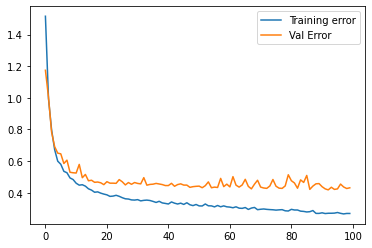

In [ ]:
# Plot the learning curve
plt.figure()
plt.plot(model_loss[:,0], label='Training error')
plt.plot(model_loss[:,1], label='Val Error')
plt.legend()

In [ ]:
# Train with internal train data to predict internal test set
n_epoch = 50
commonlit_train = CommonLitDataset(internal_train_data[['encodings', 'encoding_len']], internal_train_data['target'])
train_loader = DataLoader(commonlit_train, batch_size=batch_size, shuffle=True)

model = LSTM(embedding_dim, hidden_dim, dropout, device).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for i in range(n_epoch):
    avg_train_loss = train(model, optimizer, loss_function, train_loader, device)
    if i % 10 == 0:
        print('Iteration %d | Loss = %.4f' % (i, avg_train_loss))

commonlit_test = CommonLitDataset(internal_test_data[['encodings', 'encoding_len']])
test_loader = DataLoader(commonlit_test, batch_size=batch_size, shuffle=False)
y_pred = predict(model, test_loader, device)
print(mean_squared_error(internal_test_data['target'], y_pred, squared=False))

Iteration 0 | Loss = 1.4160
Iteration 10 | Loss = 0.4699
Iteration 20 | Loss = 0.3989
Iteration 30 | Loss = 0.3505
Iteration 40 | Loss = 0.3404
0.6541691908851036


In [ ]:
# Train with full dataset
n_epoch = 50
train_data = pd.concat([internal_train_data, internal_test_data])
commonlit_train = CommonLitDataset(train_data[['encodings', 'encoding_len']], train_data['target'])
train_loader = DataLoader(commonlit_train, batch_size=batch_size, shuffle=True)

model = LSTM(embedding_dim, hidden_dim, dropout, device).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for i in range(n_epoch):
    avg_train_loss = train(model, optimizer, loss_function, train_loader, device)
    if i % 10 == 0:
        print('Iteration %d | Loss = %.4f' % (i, avg_train_loss))

Iteration 0 | Loss = 1.3818
Iteration 10 | Loss = 0.4348
Iteration 20 | Loss = 0.3895
Iteration 30 | Loss = 0.3522
Iteration 40 | Loss = 0.3439


In [ ]:
# Predict blind test set
commonlit_test = CommonLitDataset(test_data[['encodings', 'encoding_len']])
test_loader = DataLoader(commonlit_test, batch_size=batch_size, shuffle=False)
test_data['target'] = predict(model, test_loader, device)
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)
print(submission)

          id    target
0  c0f722661 -1.444140
1  f0953f0a5 -0.345342
2  0df072751 -0.318216
3  04caf4e0c -2.357437
4  0e63f8bea -2.305949
5  12537fe78 -1.385960
6  965e592c0  0.295750
